In [ ]:
### Description of US Countrywide Traffic Accident Dataset(2016 - 2019)
# Source: https://www.kaggle.com/sobhanmoosavi/us-accidents/download

# Import Required Libraries (expand as needed)
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import tensorflow as tf
import scipy.stats as stats
import datetime
import nltk
from IPython.display import display
import statsmodels.api as sm
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.neighbors import KNeighborsClassifier, KNeighborsTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, accuracy_score, log_loss
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsTransformer, KNeighborsClassifier
from sklearn.datasets import load_digits
from sklearn.pipeline import Pipeline
from sklearn import model_selection

%matplotlib inline


## Load pre-cleaned dataset
#sys.path.append('/content/drive/My Drive/MSSM/ML_for_BDS')   #change working directory
db = pd.read_csv('/content/drive/My Drive/MSSM/ML_BDS/2_clean_US_accidents_2019.zip')

In [ ]:
# Select States for individual models
# Set state
NY_state = 'NY'
NJ_state = 'NJ'
MA_state = 'MA'
RI_state = 'RI'
CT_state = 'CT'
MD_state = 'MD'

In [ ]:
#Split Data by States
# Select the New York
NY_db = db.loc[db.State==NY_state].copy()
NY_db.drop('State', axis=1, inplace=True)

# Select New Jersey
NJ_db = db.loc[db.State==NJ_state].copy()
NJ_db.drop('State', axis=1, inplace=True)

#Select Massachusetts
MA_db = db.loc[db.State==MA_state].copy()
MA_db.drop('State', axis=1, inplace=True)

#Select Rhode Island
RI_db = db.loc[db.State==RI_state].copy()
RI_db.drop('State', axis=1, inplace=True)

#Select Conneticut
CT_db = db.loc[db.State==CT_state].copy()
CT_db.drop('State', axis=1, inplace=True)

#Select Maryland
MD_db = db.loc[db.State==MD_state].copy()
MD_db.drop('State', axis=1, inplace=True)

Feature Selection


In [ ]:
#Create dummies to deal with categorical data
# Set the list of features to include in Machine Learning
ft=['Severity','Start_Lng','Start_Lat','Distance(mi)','Side','Timezone',\
              'Temperature(F)','Wind_Chill(F)','Humidity(%)','Pressure(in)',\
              'Visibility(mi)', 'Wind_Direction','Amenity','Bump','Crossing',\
              'Give_Way','Junction','No_Exit','Railway','Roundabout','Station',\
              'Stop','Traffic_Calming', 'Traffic_Signal','Turning_Loop',\
              'Sunrise_Sunset','Civil_Twilight', 'Month', 'Nautical_Twilight',\
              'Astronomical_Twilight','Hour','Weekday', 'Time_Duration(min)']

#Subset features for each state
NY_db = NY_db[ft].copy()
NJ_db = NJ_db[ft].copy()
MA_db = MA_db[ft].copy()
RI_db = RI_db[ft].copy()
CT_db = CT_db[ft].copy()
MD_db = MD_db[ft].copy()

#make Dummies for categorical features
cat_columns = ['Side','Timezone','Sunrise_Sunset', 'Civil_Twilight', 'Month',\
              'Nautical_Twilight', 'Astronomical_Twilight', 'Weekday',\
              'Wind_Direction', 'Amenity', 'Bump', 'Crossing', 'Give_Way',\
              'Junction','No_Exit', 'Railway','Roundabout', 'Station', 'Stop',\
               'Traffic_Calming','Traffic_Signal', 'Turning_Loop']

NY_dummy = pd.get_dummies(NY_db, columns = cat_columns, drop_first = True)
NJ_dummy = pd.get_dummies(NJ_db, columns = cat_columns, drop_first = True)
MA_dummy = pd.get_dummies(MA_db, columns = cat_columns, drop_first = True)
RI_dummy = pd.get_dummies(RI_db, columns = cat_columns, drop_first = True)
CT_dummy = pd.get_dummies(CT_db, columns = cat_columns, drop_first = True)
MD_dummy = pd.get_dummies(MD_db, columns = cat_columns, drop_first = True)

#See what each looks like
print(NY_dummy.shape) #New York state
NY_dummy.head(2)

print(NJ_dummy.shape) #New Jersey
NJ_dummy.head(2)

print(MA_dummy.shape)
MA_dummy.head(2)

print(RI_dummy.shape)
RI_dummy.head(2)

print(CT_dummy.shape)
CT_dummy.head(2)

print(MD_dummy.shape)
MD_dummy.head(2)


(109441, 68)
(33860, 65)
(29734, 67)
(7515, 64)
(14813, 66)
(29304, 68)


,Severity,Start_Lng,Start_Lat,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Hour,Time_Duration(min),Side_R,Sunrise_Sunset_Night,Civil_Twilight_Night,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,Nautical_Twilight_Night,Astronomical_Twilight_Night,Weekday_Mon,Weekday_Sat,Weekday_Sun,Weekday_Thu,Weekday_Tue,Weekday_Wed,Wind_Direction_Calm,Wind_Direction_E,Wind_Direction_ENE,Wind_Direction_ESE,Wind_Direction_East,Wind_Direction_N,Wind_Direction_NE,Wind_Direction_NNE,Wind_Direction_NNW,Wind_Direction_NW,Wind_Direction_North,Wind_Direction_S,Wind_Direction_SE,Wind_Direction_SSE,Wind_Direction_SSW,Wind_Direction_SW,Wind_Direction_South,Wind_Direction_VAR,Wind_Direction_Variable,Wind_Direction_W,Wind_Direction_WNW,Wind_Direction_WSW,Wind_Direction_West,Amenity_True,Bump_True,Crossing_True,Give_Way_True,Junction_True,No_Exit_True,Railway_True,Roundabout_True,Station_True,Stop_True,Traffic_Calming_True,Traffic_Signal_True
228551,2,-76.645584,39.152046,0.01,57.9,51.326849,100.0,29.75,0.5,11,299.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
228552,3,-76.645584,39.152046,0.01,57.9,51.326849,100.0,29.75,0.5,12,299.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Only use the columns that from feature selection
select_ft =['Severity', 'Start_Lng', 'Start_Lat', 'Distance(mi)', 'Temperature(F)', \
              'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',\
              'Hour', 'Time_Duration(min)', 'Side_R', \
              'Sunrise_Sunset_Night', 'Civil_Twilight_Night', 'Month_Dec', 
              'Month_Jul', 'Month_Jun', 'Month_Nov','Month_Oct', 'Month_Sep',\
              'Nautical_Twilight_Night', 'Astronomical_Twilight_Night', \
              'Weekday_Mon', 'Weekday_Sat', 'Weekday_Sun', 'Weekday_Thu', \
              'Weekday_Tue', 'Weekday_Wed', 'Wind_Direction_Calm', 'Wind_Direction_East',\
              'Wind_Direction_NNE', 'Wind_Direction_North', 'Wind_Direction_Variable',\
              'Wind_Direction_WSW', 'Wind_Direction_West', 'Amenity_True', 'Crossing_True',\
              'Junction_True', 'Station_True', 'Stop_True', 'Traffic_Signal_True']

# Duplicate dataset with only list of selected features
NY_dummy = NY_dummy[select_ft].copy()
print(NY_dummy.shape)

NJ_dummy = NJ_dummy[select_ft].copy()
print(NJ_dummy.shape) 

MA_dummy = MA_dummy[select_ft].copy()
print(MA_dummy.shape) 

RI_dummy = RI_dummy[select_ft].copy()
print(RI_dummy.shape) 

CT_dummy = CT_dummy[select_ft].copy()
print(CT_dummy.shape)

MD_dummy = MD_dummy[select_ft].copy()
print(MD_dummy.shape) 

(109441, 41)
(33860, 41)
(29734, 41)
(7515, 41)
(14813, 41)
(29304, 41)


In [ ]:
#Set up data into train and test
# Set the target for the prediction
target='Severity'

# Create arrays for the features and the response variable
# set X and y
y_NY = NY_dummy[target]
X_NY = NY_dummy.drop(target, axis=1)

y_NJ = NJ_dummy[target]
X_NJ = NJ_dummy.drop(target, axis=1)

y_MA = MA_dummy[target]
X_MA = MA_dummy.drop(target, axis=1)

y_RI = RI_dummy[target]
X_RI = RI_dummy.drop(target, axis=1)

y_CT = CT_dummy[target]
X_CT = CT_dummy.drop(target, axis=1)

y_MD = MD_dummy[target]
X_MD = MD_dummy.drop(target, axis=1)

# Split the data set into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X_NY, y_NY, test_size=0.3, random_state=0, stratify=y_NY)

# Print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (76608, 40)
Training labels shape:  (76608,)
Test data shape:  (32833, 40)
Test labels shape:  (32833,)


In [ ]:
#Scale data before usage
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Set up loop to run alorithms simultaneously
# List of classification algorithms
names =['Random Forest', 'Logistic Regression',' K-Nearest Neighbors',\
        'Decision Tree', 'MLP Nueral Net',\
        'AdaBoost', 'Naive Bayes']

# Initialize an empty list for the accuracy for each algorithm
accuracy_list=[]


classifiers = [
    RandomForestClassifier(),
    LogisticRegression(max_iter=1000000),
    KNeighborsClassifier(n_neighbors= 8, algorithm='kd_tree'),
    DecisionTreeClassifier(),
    LinearDiscriminantAnalysis(),
    MLPClassifier(solver='lbfgs', max_iter=2000, alpha=1e-5, hidden_layer_sizes=(10,10,10)),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB()]

New York

In [ ]:
# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

RandomForestClassifier
****Results****
Accuracy: 85.0273%
Log Loss: 0.39279071507671304
LogisticRegression
****Results****
Accuracy: 68.9032%
Log Loss: 0.5795768828148233
KNeighborsClassifier
****Results****
Accuracy: 67.2037%
Log Loss: 0.994817091869792
DecisionTreeClassifier
****Results****
Accuracy: 86.9887%
Log Loss: 4.492933946853005
LinearDiscriminantAnalysis
****Results****
Accuracy: 68.0839%
Log Loss: 0.6247193858437871


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier
****Results****
Accuracy: 74.7449%
Log Loss: 0.5009316925464211
AdaBoostClassifier
****Results****
Accuracy: 56.1204%
Log Loss: 1.0806700183033289
GradientBoostingClassifier
****Results****
Accuracy: 82.7338%
Log Loss: 0.40989437463586825
GaussianNB
****Results****
Accuracy: 7.3432%
Log Loss: 29.54712705888485


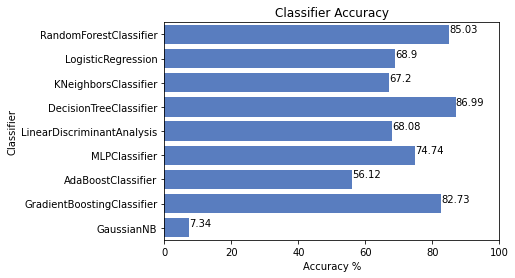

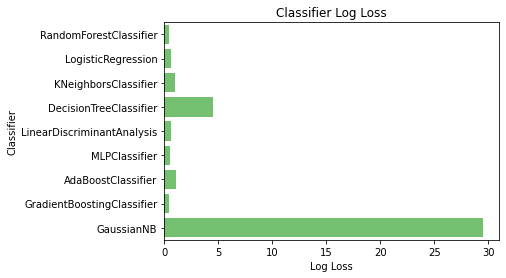

In [ ]:
#Plot graph comparing accuracies and log loss
sns.set_color_codes("muted")
g =sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")
ax = g
plt.xlim(0,100)
plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
for i in ax.patches:
    ax.text(i.get_width()+0.02, i.get_y()+0.2, str(round(i.get_width(),2)),\
            va='center', fontsize=10)
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

New Jersey


In [ ]:
# Split the data set into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X_NJ, y_NJ, test_size=0.3, random_state=0, stratify=y_NJ)

# Print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (23702, 40)
Training labels shape:  (23702,)
Test data shape:  (10158, 40)
Test labels shape:  (10158,)


In [ ]:
#Scale data before usage
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

RandomForestClassifier
****Results****
Accuracy: 81.7385%
Log Loss: 0.4483119125666701
LogisticRegression
****Results****
Accuracy: 67.6117%
Log Loss: 0.5654021611830554
KNeighborsClassifier
****Results****
Accuracy: 66.8143%
Log Loss: 0.9875246046156441
DecisionTreeClassifier
****Results****
Accuracy: 84.4654%
Log Loss: 5.362181203892034
LinearDiscriminantAnalysis
****Results****
Accuracy: 67.0801%
Log Loss: 0.6494924401975498


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier
****Results****
Accuracy: 72.9573%
Log Loss: 0.5206005251187656
AdaBoostClassifier
****Results****
Accuracy: 62.8372%
Log Loss: 1.1195220798243475
GradientBoostingClassifier
****Results****
Accuracy: 84.4261%
Log Loss: 0.4062969455270606
GaussianNB
****Results****
Accuracy: 5.3849%
Log Loss: 32.184601277994254


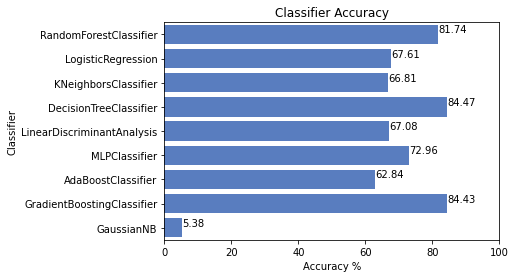

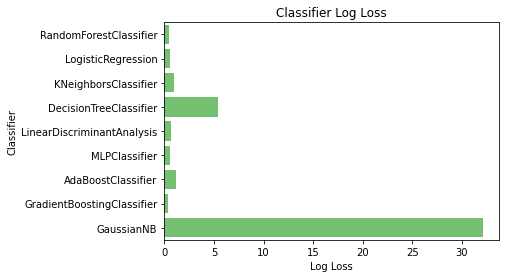

In [ ]:
#Plot graph comparing accuracies and log loss
sns.set_color_codes("muted")
g =sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")
ax = g
plt.xlim(0,100)
plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
for i in ax.patches:
    ax.text(i.get_width()+0.02, i.get_y()+0.2, str(round(i.get_width(),2)),\
            va='center', fontsize=10)
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

Massachusetts

In [ ]:
# Split the data set into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X_MA, y_MA, test_size=0.3, random_state=0, stratify=y_MA)

# Print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (20813, 40)
Training labels shape:  (20813,)
Test data shape:  (8921, 40)
Test labels shape:  (8921,)


In [ ]:
#Scale data before usage
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

RandomForestClassifier
****Results****
Accuracy: 85.2371%
Log Loss: 0.4090626364463497
LogisticRegression
****Results****
Accuracy: 68.5125%
Log Loss: 0.5660449577514671
KNeighborsClassifier
****Results****
Accuracy: 65.0039%
Log Loss: 0.8881341333145274
DecisionTreeClassifier
****Results****
Accuracy: 85.3604%
Log Loss: 5.056343680277252
LinearDiscriminantAnalysis
****Results****
Accuracy: 66.7302%
Log Loss: 0.6573536296836295


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier
****Results****
Accuracy: 77.7940%
Log Loss: 0.46628772269194213
AdaBoostClassifier
****Results****
Accuracy: 58.0540%
Log Loss: 1.0363899078493388
GradientBoostingClassifier
****Results****
Accuracy: 84.1049%
Log Loss: 0.3909868149426992
GaussianNB
****Results****
Accuracy: 26.4096%
Log Loss: 22.699861058447276


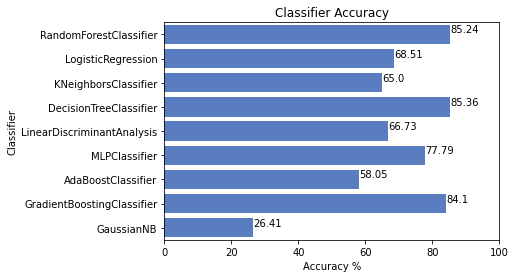

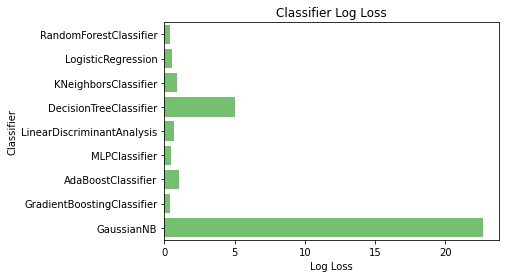

In [ ]:
#Plot graph comparing accuracies and log loss
sns.set_color_codes("muted")
g =sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")
ax = g
plt.xlim(0,100)
plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
for i in ax.patches:
    ax.text(i.get_width()+0.02, i.get_y()+0.2, str(round(i.get_width(),2)),\
            va='center', fontsize=10)
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

Rhode Island

In [ ]:
# Split the data set into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X_RI, y_RI, test_size=0.3, random_state=0, stratify=y_RI)

# Print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (5260, 40)
Training labels shape:  (5260,)
Test data shape:  (2255, 40)
Test labels shape:  (2255,)


In [ ]:
#Scale data before usage
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

RandomForestClassifier
****Results****
Accuracy: 88.9135%
Log Loss: 0.36136793426889907
LogisticRegression
****Results****
Accuracy: 70.8647%
Log Loss: 0.5894014576894147
KNeighborsClassifier
****Results****
Accuracy: 67.8492%
Log Loss: 1.3044235224588128
DecisionTreeClassifier
****Results****
Accuracy: 85.2772%
Log Loss: 5.085395525627898
LinearDiscriminantAnalysis
****Results****
Accuracy: 70.5987%
Log Loss: 0.7214360566766613


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier
****Results****
Accuracy: 83.6807%
Log Loss: 0.6508507563733368
AdaBoostClassifier
****Results****
Accuracy: 47.7162%
Log Loss: 0.7658332705295925
GradientBoostingClassifier
****Results****
Accuracy: 88.9579%
Log Loss: 0.3677623817615614
GaussianNB
****Results****
Accuracy: 56.9845%
Log Loss: 13.585054609053635


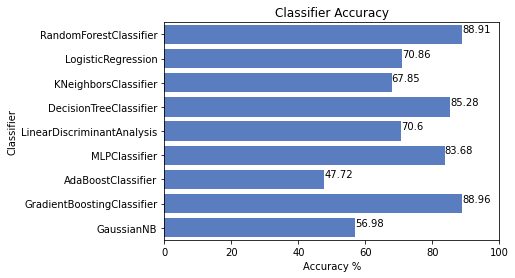

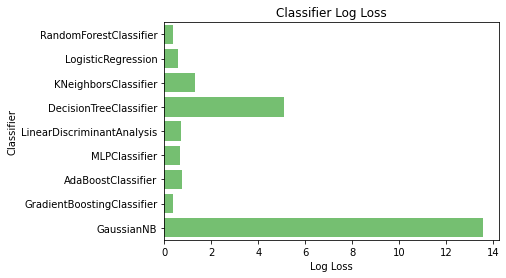

In [ ]:
#Plot graph comparing accuracies and log loss
sns.set_color_codes("muted")
g =sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")
ax = g
plt.xlim(0,100)
plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
for i in ax.patches:
    ax.text(i.get_width()+0.02, i.get_y()+0.2, str(round(i.get_width(),2)),\
            va='center', fontsize=10)
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

Conneticut

In [ ]:
# Split the data set into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X_CT, y_CT, test_size=0.3, random_state=0, stratify=y_CT)

# Print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (10369, 40)
Training labels shape:  (10369,)
Test data shape:  (4444, 40)
Test labels shape:  (4444,)


In [ ]:
#Scale data before usage
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

RandomForestClassifier
****Results****
Accuracy: 80.7606%
Log Loss: 0.5018710631332449
LogisticRegression
****Results****
Accuracy: 68.4743%
Log Loss: 0.6185827649150609
KNeighborsClassifier
****Results****
Accuracy: 64.5365%
Log Loss: 1.048046726520041
DecisionTreeClassifier
****Results****
Accuracy: 81.8182%
Log Loss: 6.279777526347398
LinearDiscriminantAnalysis
****Results****
Accuracy: 67.6418%
Log Loss: 0.6899106658542912


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier
****Results****
Accuracy: 74.7750%
Log Loss: 0.5915210292260189
AdaBoostClassifier
****Results****
Accuracy: 63.6139%
Log Loss: 1.2576297389831097
GradientBoostingClassifier
****Results****
Accuracy: 85.1485%
Log Loss: 0.43137573840444715
GaussianNB
****Results****
Accuracy: 20.5896%
Log Loss: 25.04821437618101


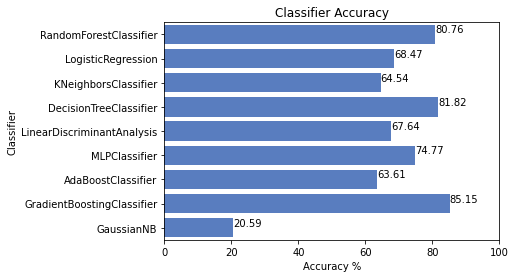

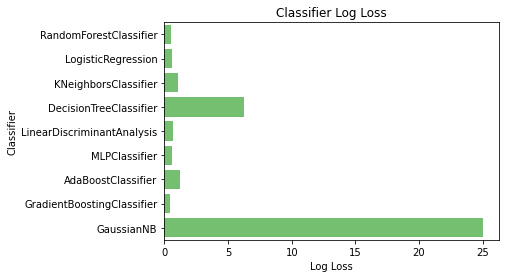

In [ ]:
#Plot graph comparing accuracies and log loss
sns.set_color_codes("muted")
g =sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")
ax = g
plt.xlim(0,100)
plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
for i in ax.patches:
    ax.text(i.get_width()+0.02, i.get_y()+0.2, str(round(i.get_width(),2)),\
            va='center', fontsize=10)
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

Maryland

In [ ]:
# Split the data set into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X_MD, y_MD, test_size=0.3, random_state=0, stratify=y_MD)

# Print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (20512, 40)
Training labels shape:  (20512,)
Test data shape:  (8792, 40)
Test labels shape:  (8792,)


In [ ]:
#Scale data before usage
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

RandomForestClassifier
****Results****
Accuracy: 82.7684%
Log Loss: 0.46546930230462547
LogisticRegression
****Results****
Accuracy: 70.8599%
Log Loss: 0.5785051909895351
KNeighborsClassifier
****Results****
Accuracy: 67.5728%
Log Loss: 1.3191821490867817
DecisionTreeClassifier
****Results****
Accuracy: 80.6870%
Log Loss: 6.666707215255295
LinearDiscriminantAnalysis
****Results****
Accuracy: 69.6542%
Log Loss: 0.7500618393430285


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier
****Results****
Accuracy: 77.4227%
Log Loss: 0.5075271039805473
AdaBoostClassifier
****Results****
Accuracy: 61.7834%
Log Loss: 1.072537039254474
GradientBoostingClassifier
****Results****
Accuracy: 81.8130%
Log Loss: 0.46669858011013327
GaussianNB
****Results****
Accuracy: 5.0387%
Log Loss: 32.362087851378945


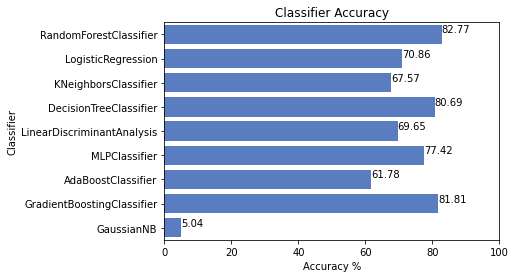

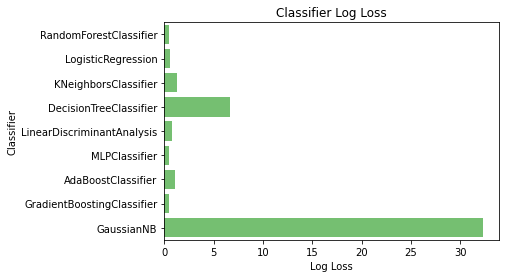

In [ ]:
#Plot graph comparing accuracies and log loss
sns.set_color_codes("muted")
g =sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")
ax = g
plt.xlim(0,100)
plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
for i in ax.patches:
    ax.text(i.get_width()+0.02, i.get_y()+0.2, str(round(i.get_width(),2)),\
            va='center', fontsize=10)
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()